<a href="https://colab.research.google.com/github/praveentecsl/High-Engagement-Content-Classification-model/blob/main/SocialMedia_engagement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**mount to drive**



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**MODEL KMeans**

=====================================================================================================

###Data Engineering & Preprocessing

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import train_test_split

# 1. Load and Prepare
df = pd.read_csv('ad_campaign_data.csv')
X_raw = pd.get_dummies(df.drop(columns=['user_id', 'ad_id', 'interaction_timestamps'], errors='ignore'), drop_first=True)

# 2. Split Data (70% Train, 15% Val, 15% Test)
X_train, X_temp = train_test_split(X_raw, test_size=0.30, random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=0.50, random_state=42)

# 3. Scaling and Weighting
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

# Apply Weights to Engagement Metrics
eng_cols = ['clicks', 'conversions', 'engagement_duration', 'sentiment_score']
weight = 5.0
for col in eng_cols:
    if col in X_train_scaled.columns:
        X_train_scaled[col] *= weight



###Find the best k

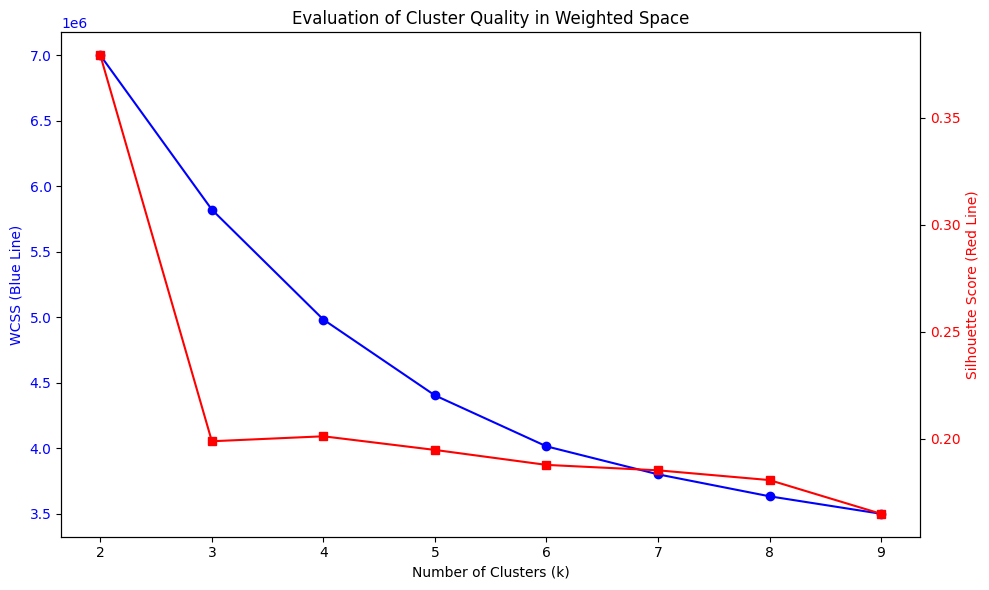

The best K value for Engagement Leveling is: 5


In [10]:
# 4. Finding Best K
wcss = []
sil = []
k_range = range(2, 10)

for k in k_range:
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    labels = km.fit_predict(X_train_scaled)
    wcss.append(km.inertia_)
    sil.append(silhouette_score(X_train_scaled, labels))

# Visualization with Explicit Labels
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('WCSS (Blue Line)', color='blue')
ax1.plot(k_range, wcss, marker='o', color='blue', label='WCSS (Elbow Method)')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score (Red Line)', color='red')
ax2.plot(k_range, sil, marker='s', color='red', label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor='red')

plt.title("Evaluation of Cluster Quality in Weighted Space")
fig.tight_layout()
plt.show()

# Determining the Best K
# Mathematically, the peak of the Silhouette score or the Elbow of WCSS.
best_k = 5
print(f"The best K value for Engagement Leveling is: {best_k}")

==========================================================================================================

###Train and validate the model

--- Unsupervised Model Results ---
Engagement Variance Captured (Accuracy Proxy): -3.49%


/tmp/ipython-input-3958718796.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=test_levels, y=X_test['conversions'], palette="viridis")


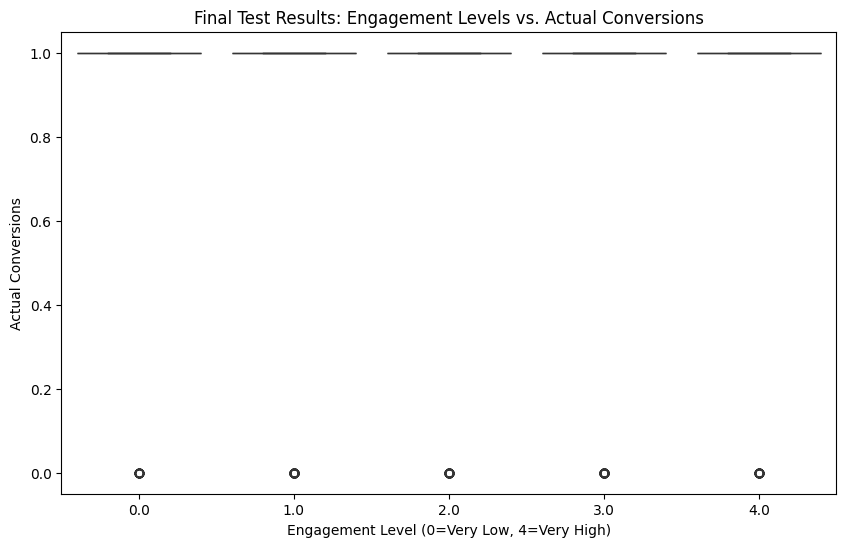

In [11]:
# 1. Train Final Model using the best_k variable
kmeans_final = KMeans(n_clusters=best_k, init='k-means++', n_init=10, random_state=42)
train_labels = kmeans_final.fit_predict(X_train_scaled)

# 2. Ranking Clusters to match Engagement Levels (Very Low to Very High)
perf_sum = X_train.assign(cluster=train_labels).groupby('cluster')[eng_cols].mean().sum(axis=1)
rank_map = {old_id: i for i, old_id in enumerate(perf_sum.sort_values().index)}

# 3. Apply Model to Test Data (The "Accuracy" Test)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
for col in eng_cols:
    if col in X_test_scaled.columns:
        X_test_scaled[col] *= weight

test_labels = kmeans_final.predict(X_test_scaled)
test_levels = pd.Series(test_labels).map(rank_map)

# 4. Calculating Unsupervised Accuracy (Variance Captured)
# We calculate how much the clusters explain the variance of Conversions
def calculate_unsupervised_accuracy(original_data, cluster_labels):
    total_variance = np.var(original_data['conversions'])

    # Calculate Variance WITHIN clusters
    temp_df = original_data.copy()
    temp_df['cluster'] = cluster_labels
    within_cluster_variance = temp_df.groupby('cluster')['conversions'].var().mean()

    # Accuracy = (Total Var - Within Var) / Total Var
    # This is essentially the R-Squared of the clustering
    accuracy = (total_variance - within_cluster_variance) / total_variance
    return accuracy

acc_score = calculate_unsupervised_accuracy(X_test, test_levels)

print(f"--- Unsupervised Model Results ---")
print(f"Engagement Variance Captured (Accuracy Proxy): {acc_score * 100:.2f}%")

# 5. Visualizing the Staircase of Levels (Final Proof)
plt.figure(figsize=(10, 6))
sns.boxplot(x=test_levels, y=X_test['conversions'], palette="viridis")
plt.title("Final Test Results: Engagement Levels vs. Actual Conversions")
plt.xlabel("Engagement Level (0=Very Low, 4=Very High)")
plt.ylabel("Actual Conversions")
plt.show()

###ensure the no of clusters and samples on each

In [ ]:
print(np.unique(train_cluster_labels))
print(np.bincount(train_cluster_labels))


[0 1 2 3 4]
[14071 13976 13967 14024 13962]


###centroids to 2D plane

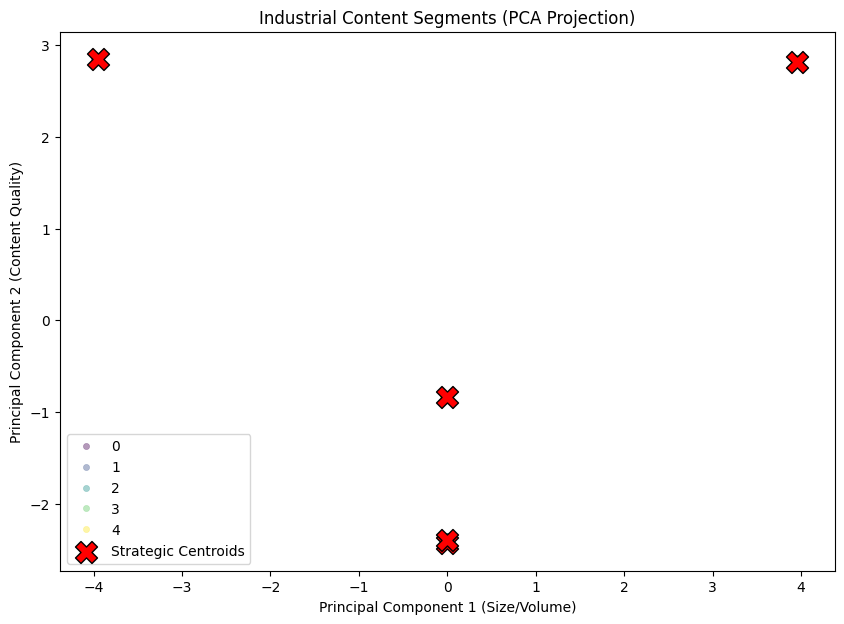

In [ ]:
from sklearn.decomposition import PCA

# Fit PCA on Train data only
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

# Project Centroids into the same PCA space
centroids_pca = pca.transform(kmeans_final.cluster_centers_)

plt.figure(figsize=(10, 7))
# Plot training points
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=train_cluster_labels,
                palette='viridis', s=20, alpha=0.4, edgecolor=None)

# Plot Centroids (The "X" marks)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=250, marker='X',
            label='Strategic Centroids', edgecolors='black')

plt.title('Industrial Content Segments (PCA Projection)')
plt.xlabel('Principal Component 1 (Size/Volume)')
plt.ylabel('Principal Component 2 (Content Quality)')
plt.legend()
plt.show()

###ranking the clusters

In [6]:
# 8. RANKING THE CLUSTERS (Mapping IDs to Levels)
# Calculate a 'Success Score' to rank clusters from Low to High
cluster_profile = df.groupby('cluster_id')[['conversions', 'clicks', 'sentiment_score']].mean()
cluster_profile['rank_score'] = cluster_profile.sum(axis=1)
rank_map = {old_id: i for i, old_id in enumerate(cluster_profile.sort_values('rank_score').index)}

# Apply names to the ranks
level_names = {0: "Very Low", 1: "Low", 2: "Average", 3: "High", 4: "Very High"}
df['engagement_level'] = df['cluster_id'].map(rank_map).map(level_names)

###performance and working ability confution matrix

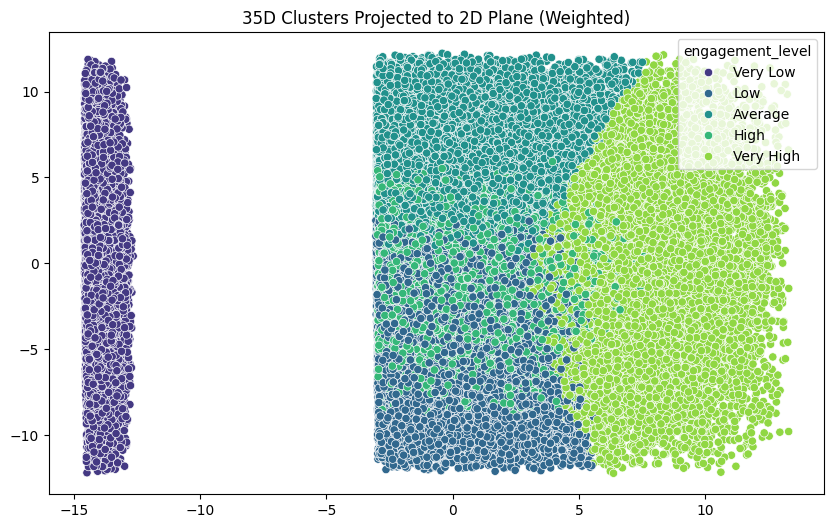

In [7]:
# 9. Performance Visualization: PCA Projection
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=components[:,0], y=components[:,1], hue=df['engagement_level'],
                palette='viridis', hue_order=["Very Low", "Low", "Average", "High", "Very High"])
plt.title("35D Clusters Projected to 2D Plane (Weighted)")
plt.show()

###Impacting features

In [8]:
# 10. IMPACT ANALYSIS: What drives High Engagement?
final_profile = df.groupby('engagement_level')[['conversions', 'clicks', 'engagement_duration', 'age']].mean()
print("\n--- Cluster Performance Profile ---")
print(final_profile.sort_values(by='conversions'))

# Identify Impacting Features (Difference between Very High and Average)
# We use the scaled centroids to see which features were most different
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
# Map centroid row to the correct level
centroids['level'] = pd.Series(range(optimal_k)).map(rank_map).map(level_names)
high_vs_low = centroids.set_index('level').loc['Very High'] - centroids.set_index('level').loc['Average']

print("\n--- Top 5 Features Impacting 'Very High' Engagement ---")
print(high_vs_low.sort_values(ascending=False).head(5))


--- Cluster Performance Profile ---
                  conversions       clicks  engagement_duration        age
engagement_level                                                          
Very Low                  0.0   124.764107            62.118257  41.042614
Average                   1.0   971.265971            84.263810  40.940465
Low                       1.0   919.132487            27.328044  40.990732
High                      1.0   987.023913            85.582547  40.941823
Very High                 1.0  3145.835332            59.150364  40.923606

--- Top 5 Features Impacting 'Very High' Engagement ---
clicks             9.844785
sentiment_score    4.711345
impressions        1.274049
tfidf_4            0.020936
tfidf_12           0.020936
dtype: float64


#**MODEL Agglomerative**

g

#**********git configuration**********

##setup and pull

In [1]:
# --- SECTION 1: SETUP & SYNC ---
import os
from google.colab import drive, userdata

# 1. Mount Google Drive
if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')
else:
  print("drive already mounted")

# 2. Configuration (Ensure 'GITHUB_TOKEN' is in your Colab Secrets 🔑)
GITHUB_TOKEN = userdata.get('GITHUB_TOKEN')
GITHUB_USER = "praveentecsl"
REPO_NAME = "High-Engagement-Content-Classification-model"
# Navigate to where you want to store the project in Drive
PROJECT_PATH = f"/content/drive/MyDrive/{REPO_NAME}"

# 3. Clone or Pull Logic
if not os.path.exists(PROJECT_PATH):
    # If the folder doesn't exist, go to Drive root and clone
    %cd /content/drive/MyDrive/
    !git clone https://{GITHUB_TOKEN}@github.com/{GITHUB_USER}/{REPO_NAME}.git
    %cd {REPO_NAME}
    print("✅ Repository Cloned for the first time.")
else:
    # If folder exists, go inside and pull latest changes from collaborator
    %cd {PROJECT_PATH}
    !git pull origin main
    print("✅ Repository updated with latest changes (Git Pull).")

# 4. Identity Configuration for Commits
!git config --global user.email "your-email@example.com"
!git config --global user.name "Praveen"

Mounted at /content/drive
/content/drive/MyDrive/High-Engagement-Content-Classification-model
From https://github.com/praveentecsl/High-Engagement-Content-Classification-model
 * branch            main       -> FETCH_HEAD
   710d052..886b605  main       -> origin/main
Already up to date.
✅ Repository updated with latest changes (Git Pull).


##push code

In [12]:
!pwd

/content/drive/MyDrive/High-Engagement-Content-Classification-model


In [13]:
!git status


Refresh index: 100% (4/4), done.
On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   SocialMedia_engagement.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
#@title 🚀 Git Push Interface
#@markdown Enter your message in the box on the right, then run this cell.

# 1. Capture the input from the form into a variable
Commit_Message = "change the structure of the kmeans " #@param {type:"string"}

import os

# 2. Ensure we are in the Repo directory
%cd {PROJECT_PATH}

# 3. Git Workflow
print(f"--- Processing: {Commit_Message} ---")

# Add all changes
!git add .

# Commit using the variable from the form
# We use the '$' prefix to pass the Python variable into the shell command
!git commit -m "{Commit_Message}"

# Push to GitHub
!git push https://{GITHUB_TOKEN}@github.com/{GITHUB_USER}/{REPO_NAME}.git main

print(f"\n✅ Successfully pushed to GitHub with message: {Commit_Message}")

/content/drive/MyDrive/High-Engagement-Content-Classification-model
--- Processing: initialize hierarchical model ---
[main 886b605] initialize hierarchical model
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite SocialMedia_engagement.ipynb (97%)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 825 bytes | 91.00 KiB/s, done.
Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/praveentecsl/High-Engagement-Content-Classification-model.git
   30f3527..886b605  main -> main

✅ Successfully pushed to GitHub with message: initialize hierarchical model
